# Evaluating Multi-Modal RAG

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [ ]:
%pip install llama_index ftfy regex tqdm -q
%pip install git+https://github.com/openai/CLIP.git -q
%pip install torch torchvision -q
%pip install matplotlib scikit-image -q
%pip install -U qdrant_client -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Spelling In ASL

Load in our data

In [ ]:
from llama_index.multi_modal_llms.generic_utils import (
    load_image_urls,
)
from llama_index import SimpleDirectoryReader

image_path = "/Users/nerdai/Datasets/Images/asl-labelled"
image_documents = SimpleDirectoryReader(image_path).load_data()

In [ ]:
# from llama_index.multi_modal_llms.openai import OpenAIMultiModal

# openai_mm_llm = OpenAIMultiModal(
#     model="gpt-4-vision-preview", max_new_tokens=300
# )

In [ ]:
# response = openai_mm_llm.complete(
#     prompt="Describe the image that depicts a letter from the alphabet sign language?",
#     image_documents=[image_documents[0]],
# )

Create the asl vector index

In [ ]:
from llama_index.schema import Document, ImageNode, TextNode

LETTERS = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    "SPACE",
]

text_documents = [Document(text=letter) for letter in LETTERS]

In [ ]:
documents = image_documents + text_documents

In [ ]:
len(documents)

54

In [ ]:
client.close()

In [ ]:
from llama_index.vector_stores import QdrantVectorStore
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index import StorageContext, ServiceContext
from llama_index.embeddings import OpenAIEmbedding
import qdrant_client

# create vector stores
# can't just use a plain VectorStoreIndex?
client = qdrant_client.QdrantClient(path="qdrant_labelled")

text_store = QdrantVectorStore(
    client=client,
    collection_name="text_collection",
)
storage_context = StorageContext.from_defaults(vector_store=text_store)

image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)

# use clip for text encoding as well
service_context = ServiceContext.from_defaults(embed_model=OpenAIEmbedding())

asl_index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    service_context=service_context,
    image_vector_store=image_store,
)

In [ ]:
# from llama_index.schema import ImageNode

# # retrieve more information from the GPT4V response
# retrieval_results = retriever_engine.retrieve("B")

# image_node = None
# for r in retrieval_results:
#     if isinstance(r.node, ImageNode):
#         image_node = r
#         break

# img_path = image_node.metadata["file_path"]
# image = Image.open(img_path).convert("RGB")

# plt.imshow(image)

In [ ]:
# use as retriever
retriever_engine = asl_index.as_retriever(image_similarity_top_k=1)

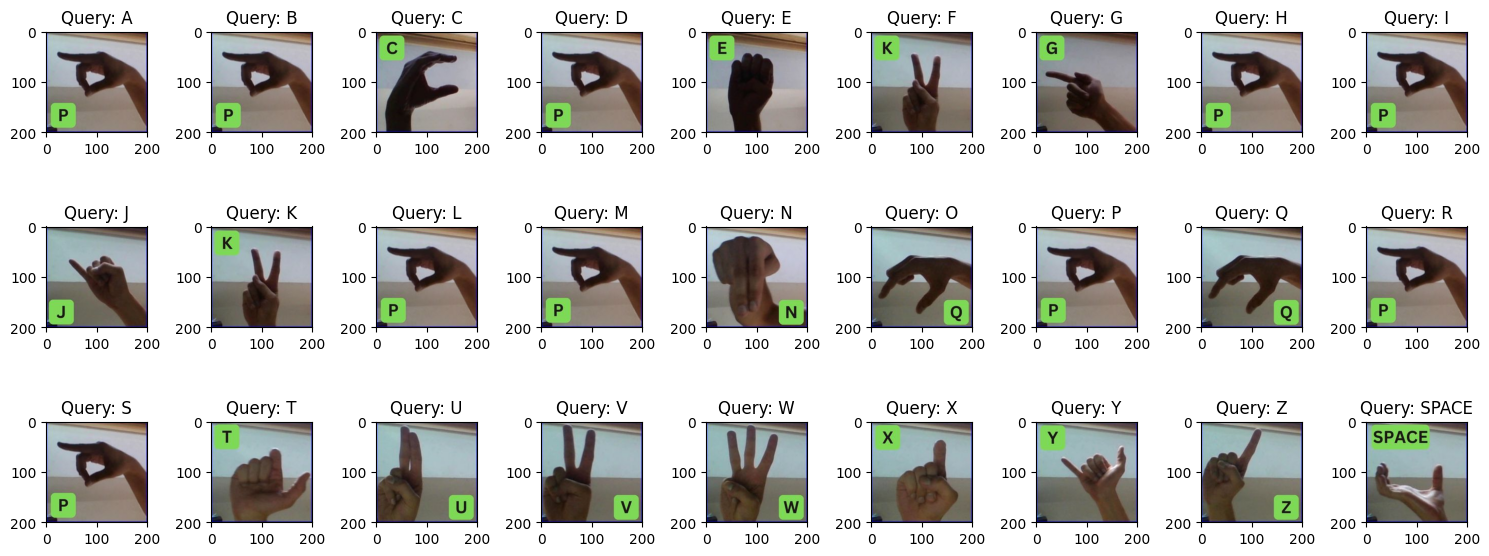

In [ ]:
f, axarr = plt.subplots(3, 9)
f.set_figheight(6)
f.set_figwidth(15)
ix = 0
for jx, letter in enumerate(LETTERS):
    retrieval_results = retriever_engine.retrieve(letter)
    image_node = None
    text_node = None
    for r in retrieval_results:
        if isinstance(r.node, TextNode):
            text_node = r
        if isinstance(r.node, ImageNode):
            image_node = r
            break

    img_path = image_node.metadata["file_path"]
    image = Image.open(img_path).convert("RGB")
    axarr[int(jx / 9), jx % 9].imshow(image)
    axarr[int(jx / 9), jx % 9].set_title(f"Query: {letter}")

plt.setp(axarr, xticks=[0, 100, 200], yticks=[0, 100, 200])
f.tight_layout()
plt.show()

### Hit Rate and MRR

## RAG

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.multi_modal_llms.replicate_multi_modal import (
    ReplicateMultiModal,
)

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", max_new_tokens=300
)

multi_modal_llm = ReplicateMultiModal(
    model="yorickvp/llava-13b:2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591",
    max_new_tokens=300,
)

In [ ]:
from llama_index.prompts import PromptTemplate

qa_tmpl_str = (
    "Images of hand gestures for ASL are provided.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Using only the images provided, "
    "answer the query. If the image is not helpful, don't provide an answer.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = asl_index.as_query_engine(
    multi_modal_llm=multi_modal_llm, text_qa_template=qa_tmpl
)

In [ ]:
query_str = "How can I sign a space? Use only the image provided."
response = query_engine.query(query_str)

### Retriever Evaluation

#### Hit Rate and MRR 

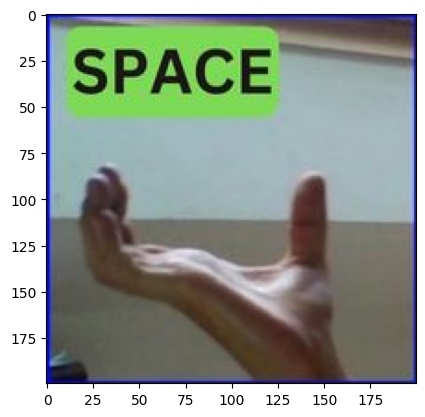

In [ ]:
img_doc = response.metadata["image_nodes"][0].node
img_path = img_doc.metadata["file_path"]
image = Image.open(img_path).convert("RGB")

plt.imshow(image)

In [ ]:
text_doc = response.metadata["text_nodes"][0].node
text_doc.text

'P'

### Generation Evaluation

In [ ]:
print(str(response))

To sign space using only the image provided, you would hold your hand out with your palm facing upwards, as if you are holding an empty cup or a ball. The space image shows a hand with a palm facing upwards, which can be interpreted as the concept of space.


#### Human Agreement

#### LMM-As-A-Judge